In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


In [2]:
# ================== Cell 1: Import libraries ==================
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
import shap

In [3]:
# Load the preprocessed dataset
df = pd.read_csv('/content/test.csv')  # change path if needed

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (1200, 11)
Columns: ['gender', 'age', 'RBC', 'Hb', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW_CV', 'RDW_SD', 'LABEL']


,gender,age,RBC,Hb,HCT,MCV,MCH,MCHC,RDW_CV,RDW_SD,LABEL
0,1,22,4.11,110,0.346,84.2,26.8,318,0.16,47.4,0
1,0,25,5.23,141,0.423,80.9,27.0,333,0.12,36.1,0
2,1,31,4.83,75,0.281,58.2,15.5,267,0.19,37.2,0
3,0,22,6.91,143,0.452,65.4,20.7,316,0.19,38.1,0
4,0,28,6.22,136,0.438,70.4,21.9,311,0.14,33.8,0


In [4]:
# ================== Cell 3: Check missing values & dtypes ==================
print("Missing values per column:")
print(df.isna().sum())

print("\nColumn data types:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe(include="all"))

Missing values per column:
gender    0
age       0
RBC       0
Hb        0
HCT       0
MCV       0
MCH       0
MCHC      0
RDW_CV    0
RDW_SD    0
LABEL     0
dtype: int64

Column data types:
gender      int64
age         int64
RBC       float64
Hb          int64
HCT       float64
MCV       float64
MCH       float64
MCHC        int64
RDW_CV    float64
RDW_SD    float64
LABEL       int64
dtype: object

Basic statistics:
            gender          age          RBC           Hb          HCT  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean      0.580000    34.736667     4.581208   116.765000     0.358929   
std       0.493764    16.094767     1.037381    28.283589     0.077648   
min       0.000000     0.000000     1.310000    41.000000     0.141000   
25%       0.000000    26.000000     3.890000    97.000000     0.303000   
50%       1.000000    32.000000     4.665000   116.000000     0.356000   
75%       1.000000    41.000000     5.252500   140.000000  

In [5]:
# ================== Cell 4: Identify numeric & categorical ==================
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Treat low-unique integer columns as categorical (if not IDs)
id_like = [c for c in df.columns if c.lower() in ["id","patientid","recordid","caseid"]]

for c in df.select_dtypes(include=[np.integer]).columns:
    if c in id_like:
        continue
    if df[c].nunique() < 0.05 * len(df):  # heuristic
        if c not in cat_cols:
            cat_cols.append(c)
        if c in numeric_cols:
            numeric_cols.remove(c)

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)
print("ID-like columns:", id_like)

Numeric columns: ['age', 'RBC', 'Hb', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW_CV', 'RDW_SD']
Categorical columns: ['gender', 'LABEL']
ID-like columns: []


In [6]:
# ================== Cell 5: Impute missing values ==================
df_proc = df.copy()

# Numeric imputation (median)
if numeric_cols:
    num_imp = SimpleImputer(strategy="median")
    df_proc[numeric_cols] = num_imp.fit_transform(df_proc[numeric_cols])

# Categorical imputation (Unknown)
if cat_cols:
    cat_imp = SimpleImputer(strategy="constant", fill_value="Unknown")
    df_proc[cat_cols] = cat_imp.fit_transform(df_proc[cat_cols].astype(str))

print("Missing values after imputation:")
print(df_proc.isna().sum().sum())

Missing values after imputation:
0


In [7]:
# ================== Cell 6: Encode categorical (explainable) ==================
for c in cat_cols:
    df_proc[c + "_code"] = pd.Categorical(df_proc[c]).codes

print("Added categorical code columns (suffix _code).")

Added categorical code columns (suffix _code).


In [8]:
# ================== Cell 7: Scale numeric columns ==================
scaler = StandardScaler()
scaled_cols = [c + "_scaled" for c in numeric_cols]
df_proc[scaled_cols] = scaler.fit_transform(df_proc[numeric_cols])

print("Added scaled numeric columns (suffix _scaled).")

Added scaled numeric columns (suffix _scaled).


In [9]:
# ================== Cell 8: Detect target column ==================
candidate_targets = ["label","target","diagnosis","disease","has_disease","outcome","status","y"]

detected_target = None
for c in df_proc.columns:
    if c.lower() in candidate_targets:
        detected_target = c
        break

if not detected_target:
    for c in df_proc.columns:
        if df_proc[c].nunique() == 2 and c.lower() not in id_like:
            detected_target = c
            break

print("Detected target column:", detected_target)

Detected target column: LABEL


In [10]:
# ================== Cell 9: Check class balance ==================
if detected_target:
    print(df_proc[detected_target].value_counts())
    print(df_proc[detected_target].value_counts(normalize=True))

LABEL
0    600
1    600
Name: count, dtype: int64
LABEL
0    0.5
1    0.5
Name: proportion, dtype: float64


In [11]:
# ================== Cell 10: Save processed file ==================
df_proc.to_csv("processed_test.csv", index=False)
print("Processed dataset saved as processed_test.csv")

df_proc.head()

Processed dataset saved as processed_test.csv


,gender,age,RBC,Hb,HCT,MCV,MCH,MCHC,RDW_CV,RDW_SD,...,LABEL_code,age_scaled,RBC_scaled,Hb_scaled,HCT_scaled,MCV_scaled,MCH_scaled,MCHC_scaled,RDW_CV_scaled,RDW_SD_scaled
0,1,22.0,4.11,110.0,0.346,84.2,26.8,318.0,0.16,47.4,...,0,-0.791684,-0.454418,-0.239284,-0.166579,0.413181,0.194945,-0.287011,0.086787,0.518712
1,0,25.0,5.23,141.0,0.423,80.9,27.0,333.0,0.12,36.1,...,0,-0.605211,0.625674,0.857215,0.825484,0.126682,0.236544,0.455792,-0.962529,-0.762642
2,1,31.0,4.83,75.0,0.281,58.2,15.5,267.0,0.19,37.2,...,0,-0.232263,0.239927,-1.477267,-1.004034,-1.844086,-2.155416,-2.812540,0.873775,-0.637908
3,0,22.0,6.91,143.0,0.452,65.4,20.7,316.0,0.19,38.1,...,0,-0.791684,2.245813,0.927956,1.199118,-1.218996,-1.073834,-0.386051,0.873775,-0.535854
4,0,28.0,6.22,136.0,0.438,70.4,21.9,311.0,0.14,33.8,...,0,-0.418737,1.580399,0.680360,1.018743,-0.784907,-0.824238,-0.633652,-0.437871,-1.023449


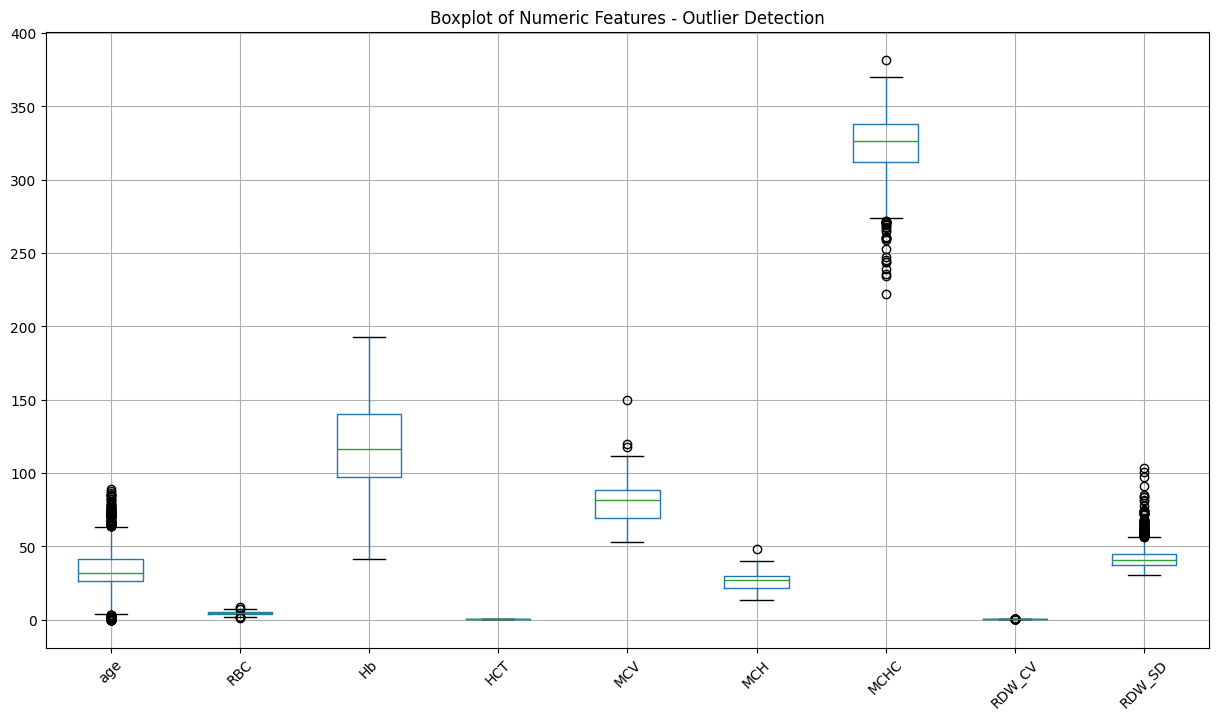

In [12]:
plt.figure(figsize=(15, 8))
df_proc[numeric_cols].boxplot()
plt.title("Boxplot of Numeric Features - Outlier Detection")
plt.xticks(rotation=45)
plt.show()

In [13]:
# ================== Cell 7: Outlier Removal (IQR Method) ==================
Q1 = df_proc[numeric_cols].quantile(0.25)
Q3 = df_proc[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Keep only non-outliers
df_proc = df_proc[~((df_proc[numeric_cols] < (Q1 - 1.5 * IQR)) |
                    (df_proc[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Shape after outlier removal:", df_proc.shape)

Shape after outlier removal: (944, 22)


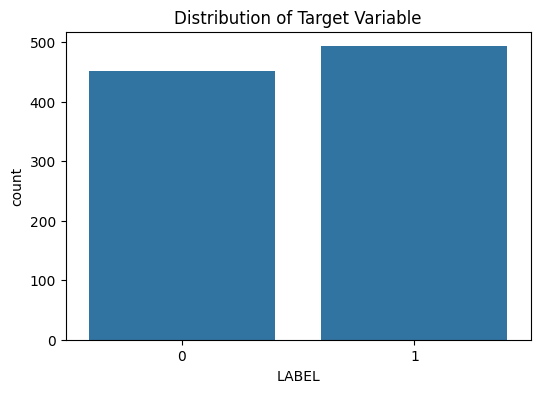

In [14]:
# ================== Cell 7: Target Variable Distribution ==================
if detected_target:
    plt.figure(figsize=(6,4))
    sns.countplot(x=detected_target, data=df_proc)
    plt.title("Distribution of Target Variable")
    plt.show()

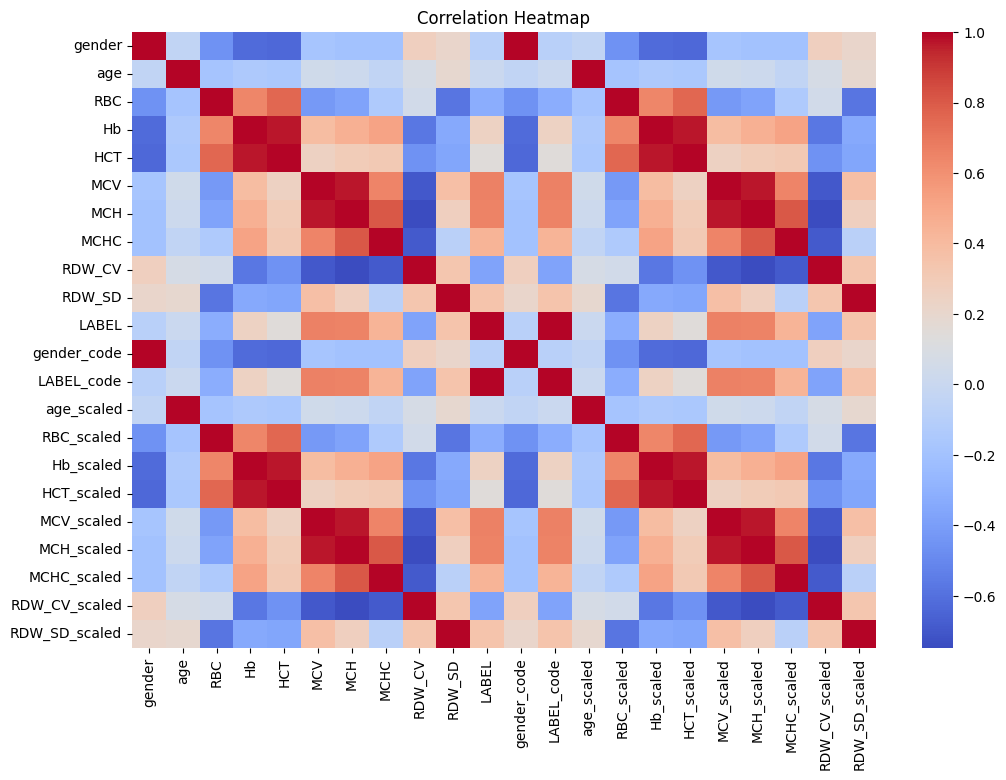

In [15]:
# ================== Cell 8: Correlation Heatmap ==================
plt.figure(figsize=(12, 8))
sns.heatmap(df_proc.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [16]:
target_col = 'LABEL'
X = df.drop(target_col, axis=1)
y = df[target_col]

In [17]:
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [18]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42 )

In [19]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:52:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:,1]

In [21]:
print("\n===== XGBoost Results =====")
print("Accuracy:", round(accuracy_score(y_test, xgb_pred),4))
print("Precision:", round(precision_score(y_test, xgb_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, xgb_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, xgb_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, xgb_prob),4))
print(classification_report(y_test, xgb_pred, zero_division=0))


===== XGBoost Results =====
Accuracy: 0.8083
Precision: 0.7803
Recall: 0.8583
F1: 0.8175
ROC-AUC: 0.9104
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       120
           1       0.78      0.86      0.82       120

    accuracy                           0.81       240
   macro avg       0.81      0.81      0.81       240
weighted avg       0.81      0.81      0.81       240



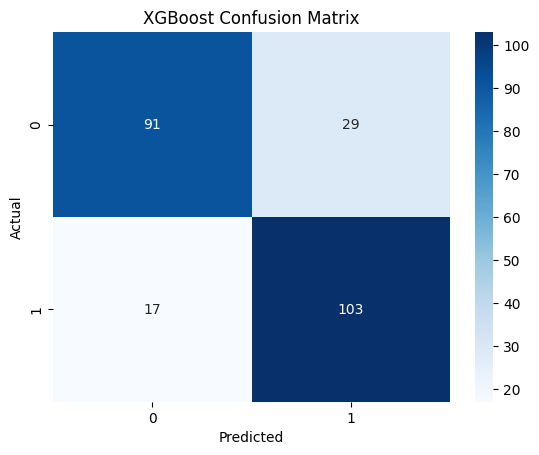

In [22]:
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

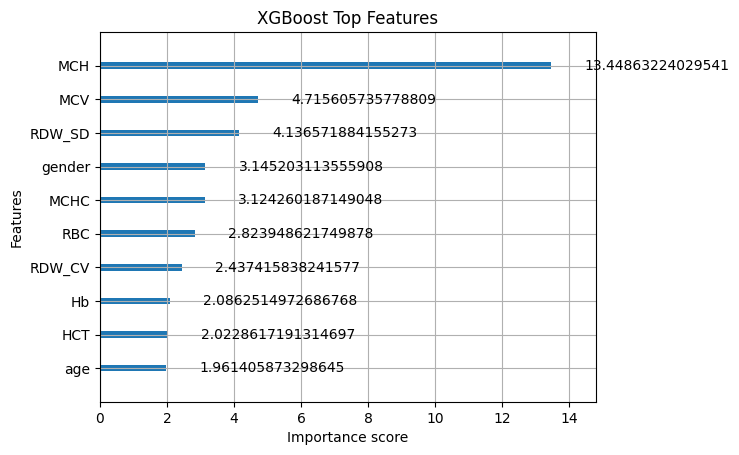

In [23]:
# Feature Importance (built-in)

xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("XGBoost Top Features")
plt.show()

In [24]:
# ====== 6. CatBoost Classifier ======
# ==========================================
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_state=42,
    verbose=0
)
cat_model.fit(X_train, y_train)

In [25]:
# ====== Evaluate CatBoost ======
cat_pred = cat_model.predict(X_test)
cat_prob = cat_model.predict_proba(X_test)[:,1]

In [26]:
print("\n===== CatBoost Results =====")
print("Accuracy:", round(accuracy_score(y_test, cat_pred),4))
print("Precision:", round(precision_score(y_test, cat_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, cat_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, cat_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, cat_prob),4))
print(classification_report(y_test, cat_pred, zero_division=0))



===== CatBoost Results =====
Accuracy: 0.7958
Precision: 0.771
Recall: 0.8417
F1: 0.8048
ROC-AUC: 0.9019
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       120
           1       0.77      0.84      0.80       120

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240



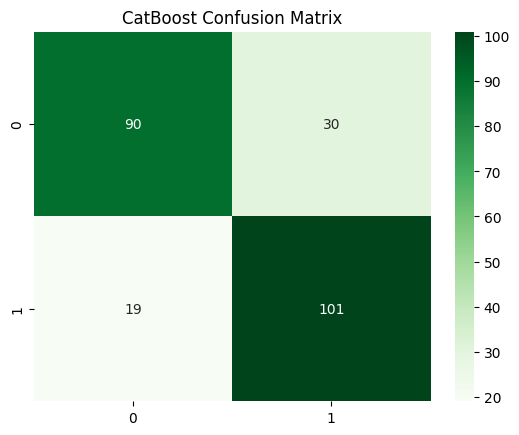

In [27]:
cm = confusion_matrix(y_test, cat_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("CatBoost Confusion Matrix")
plt.show()

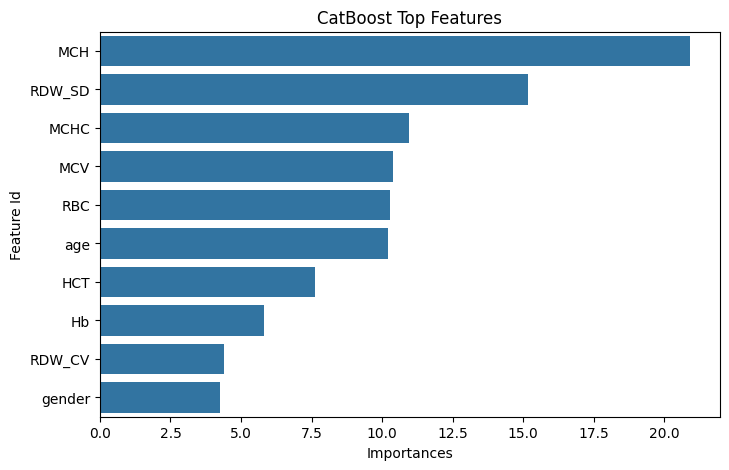

In [28]:
# CatBoost feature importance
feat_importance = cat_model.get_feature_importance(prettified=True)
plt.figure(figsize=(8,5))
sns.barplot(x='Importances', y='Feature Id', data=feat_importance.sort_values('Importances', ascending=False).head(10))
plt.title("CatBoost Top Features")
plt.show()


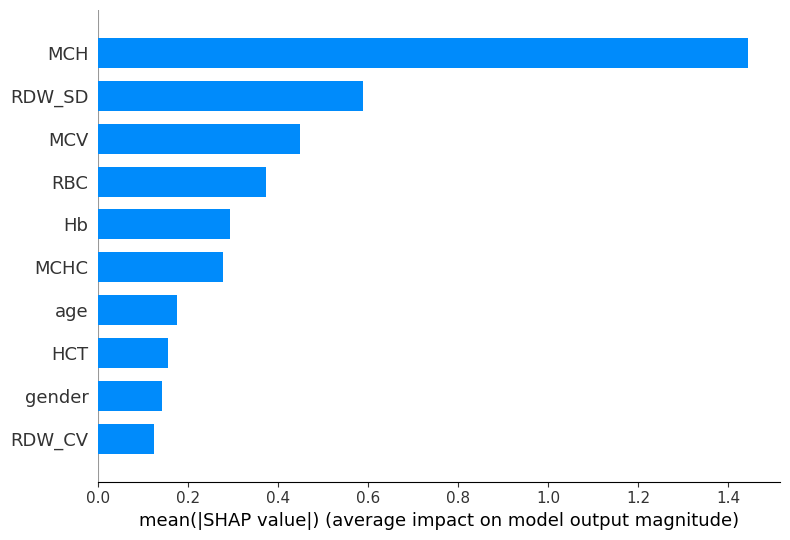

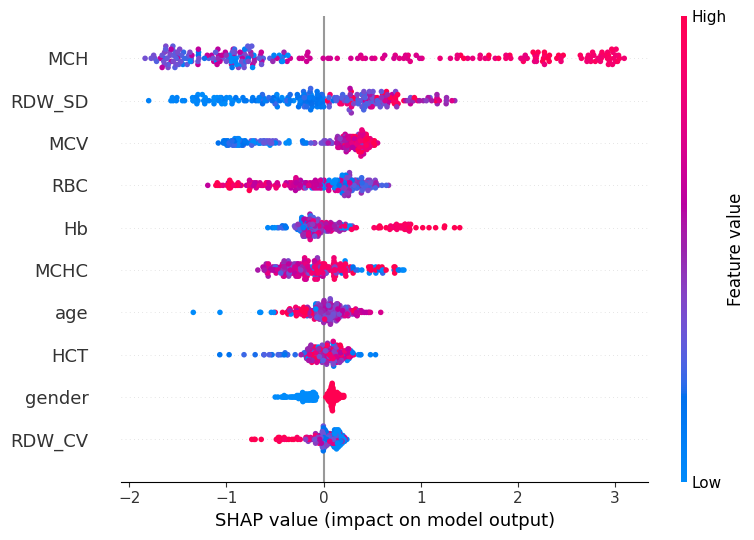

In [29]:
# ====== 7. SHAP Explainability ======
# XGBoost SHAP
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar", show=True)
print(" ")
shap.summary_plot(xgb_shap_values, X_test, show=True)

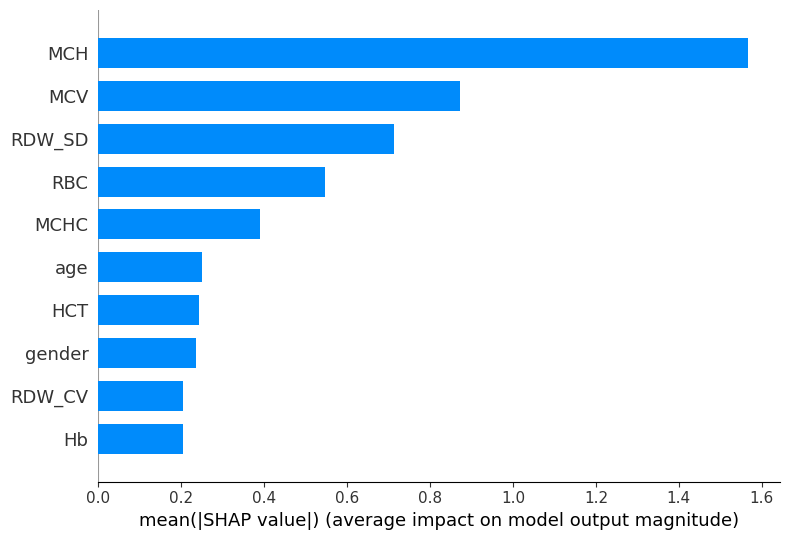

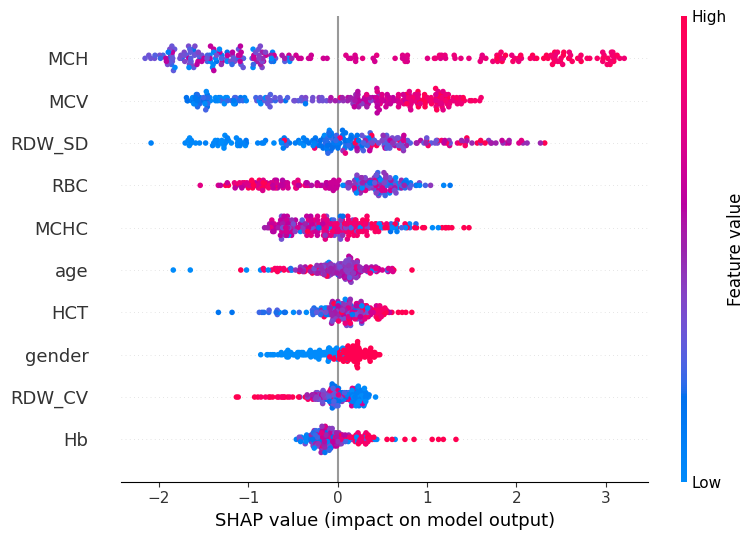

In [30]:
cat_explainer = shap.TreeExplainer(cat_model)
cat_shap_values = cat_explainer.shap_values(X_test)
shap.summary_plot(cat_shap_values, X_test, plot_type="bar", show=True)
print(" ")

shap.summary_plot(cat_shap_values, X_test, show=True)

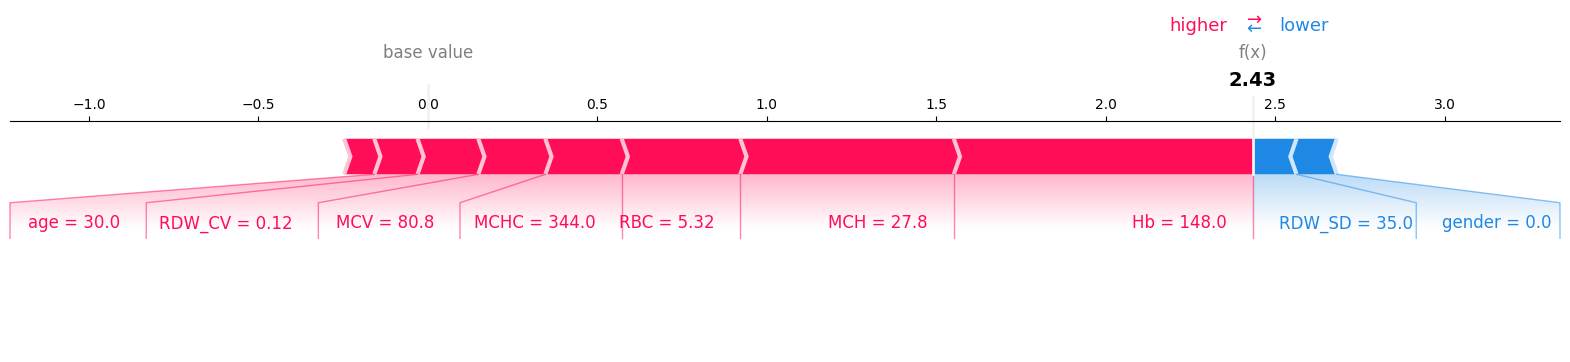

In [31]:
# Force plot for a single prediction
sample_index = 0   # pick the first test patient
shap.initjs()
shap.force_plot(
    xgb_explainer.expected_value,
    xgb_shap_values[sample_index,:],
    X_test.iloc[sample_index,:],
    matplotlib=True
)

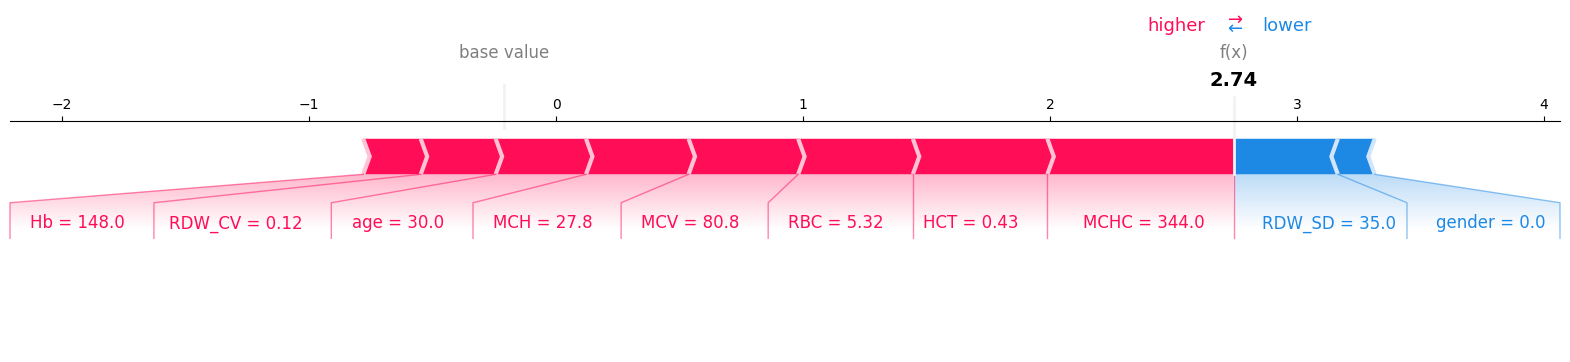

In [32]:
sample_index = 0
shap.initjs()
shap.force_plot(
    cat_explainer.expected_value,
    cat_shap_values[sample_index,:],
    X_test.iloc[sample_index,:],
    matplotlib=True
)

In [33]:
from sklearn.ensemble import VotingClassifier

# Ensemble: VotingClassifier with soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),            # Fitted XGBoost model
        ('cat', cat_model)             # Fitted CatBoost model
    ],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)
ensemble_pred = ensemble_model.predict(X_test)
ensemble_prob = ensemble_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

print("Ensemble Results")
print("Accuracy:", round(accuracy_score(y_test, ensemble_pred), 4))
print("Precision:", round(precision_score(y_test, ensemble_pred, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, ensemble_pred, zero_division=0), 4))
print("F1:", round(f1_score(y_test, ensemble_pred, zero_division=0), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, ensemble_prob), 4))
print(classification_report(y_test, ensemble_pred, zero_division=0))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:52:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Results
Accuracy: 0.7958
Precision: 0.7669
Recall: 0.85
F1: 0.8063
ROC-AUC: 0.9065
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       120
           1       0.77      0.85      0.81       120

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240



In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('cat', cat_model),
        # Add more models if needed
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)

print("Stacking Ensemble Accuracy:", round(accuracy_score(y_test, stacking_pred), 4))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:53:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:53:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:53:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:53:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:53:06] WARNING: /w

Stacking Ensemble Accuracy: 0.8125


In [35]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


===== SVM Results =====
Accuracy: 0.7208
Precision: 0.6963
Recall: 0.7833
F1: 0.7373
ROC-AUC: 0.8196
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       120
           1       0.70      0.78      0.74       120

    accuracy                           0.72       240
   macro avg       0.72      0.72      0.72       240
weighted avg       0.72      0.72      0.72       240



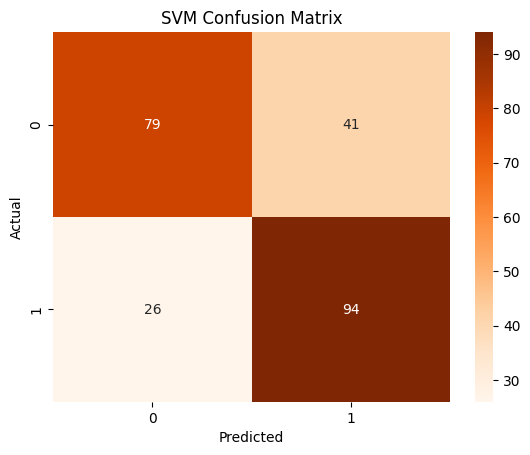

In [36]:
# SVM Classifier (use probability for ROC-AUC)
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)
svm_prob = svm_model.predict_proba(X_test)[:, 1]

print("\n===== SVM Results =====")
print("Accuracy:", round(accuracy_score(y_test, svm_pred),4))
print("Precision:", round(precision_score(y_test, svm_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, svm_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, svm_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, svm_prob),4))
print(classification_report(y_test, svm_pred, zero_division=0))

cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



===== Decision Tree Results =====
Accuracy: 0.7625
Precision: 0.7692
Recall: 0.75
F1: 0.7595
ROC-AUC: 0.7625
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       120
           1       0.77      0.75      0.76       120

    accuracy                           0.76       240
   macro avg       0.76      0.76      0.76       240
weighted avg       0.76      0.76      0.76       240



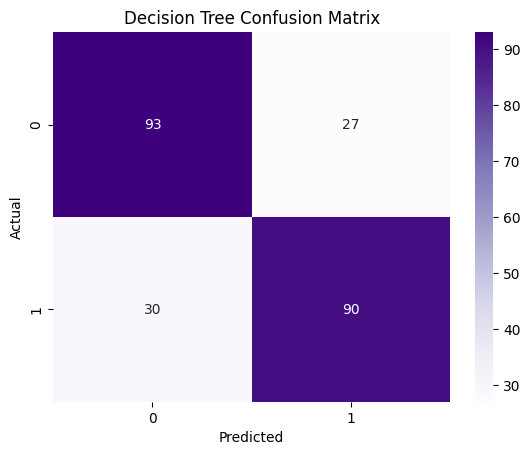

In [37]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
dt_prob = dt_model.predict_proba(X_test)[:, 1]

print("\n===== Decision Tree Results =====")
print("Accuracy:", round(accuracy_score(y_test, dt_pred),4))
print("Precision:", round(precision_score(y_test, dt_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, dt_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, dt_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, dt_prob),4))
print(classification_report(y_test, dt_pred, zero_division=0))

cm = confusion_matrix(y_test, dt_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

print("\n===== Random Forest Results =====")
print("Accuracy:", round(accuracy_score(y_test, rf_pred),4))
print("Precision:", round(precision_score(y_test, rf_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, rf_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, rf_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, rf_prob),4))
print(classification_report(y_test, rf_pred, zero_division=0))



===== Random Forest Results =====
Accuracy: 0.7833
Precision: 0.7656
Recall: 0.8167
F1: 0.7903
ROC-AUC: 0.9059
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       120
           1       0.77      0.82      0.79       120

    accuracy                           0.78       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.78      0.78      0.78       240



Logistic Regression


In [39]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]

print("\n===== Logistic Regression Results =====")
print("Accuracy:", round(accuracy_score(y_test, lr_pred),4))
print("Precision:", round(precision_score(y_test, lr_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, lr_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, lr_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, lr_prob),4))
print(classification_report(y_test, lr_pred, zero_division=0))



===== Logistic Regression Results =====
Accuracy: 0.7625
Precision: 0.7299
Recall: 0.8333
F1: 0.7782
ROC-AUC: 0.8558
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       120
           1       0.73      0.83      0.78       120

    accuracy                           0.76       240
   macro avg       0.77      0.76      0.76       240
weighted avg       0.77      0.76      0.76       240



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K-Nearest Neighbors (KNN)



In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

knn_pred = knn_model.predict(X_test)
knn_prob = knn_model.predict_proba(X_test)[:, 1]

print("\n===== KNN Results =====")
print("Accuracy:", round(accuracy_score(y_test, knn_pred),4))
print("Precision:", round(precision_score(y_test, knn_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, knn_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, knn_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, knn_prob),4))
print(classification_report(y_test, knn_pred, zero_division=0))



===== KNN Results =====
Accuracy: 0.7792
Precision: 0.7519
Recall: 0.8333
F1: 0.7905
ROC-AUC: 0.8608
              precision    recall  f1-score   support

           0       0.81      0.72      0.77       120
           1       0.75      0.83      0.79       120

    accuracy                           0.78       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.78      0.78      0.78       240



Naive Bayes



In [41]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]

print("\n===== Naive Bayes Results =====")
print("Accuracy:", round(accuracy_score(y_test, nb_pred),4))
print("Precision:", round(precision_score(y_test, nb_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, nb_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, nb_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, nb_prob),4))
print(classification_report(y_test, nb_pred, zero_division=0))



===== Naive Bayes Results =====
Accuracy: 0.7417
Precision: 0.7101
Recall: 0.8167
F1: 0.7597
ROC-AUC: 0.8325
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       120
           1       0.71      0.82      0.76       120

    accuracy                           0.74       240
   macro avg       0.75      0.74      0.74       240
weighted avg       0.75      0.74      0.74       240



Hyperparameter tuning using cross-validation can be performed in scikit-learn using GridSearchCV or RandomizedSearchCV. Here is a practical example for Random Forest, but you can apply the same approach to any classifier by changing the model and parameter grid.

Example: Random Forest with GridSearchCV

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best parameters and best model
print("Best parameters found:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate on test data
rf_pred = best_rf.predict(X_test)
rf_prob = best_rf.predict_proba(X_test)[:,1]

print("\n===== Tuned Random Forest Results =====")
print("Accuracy:", round(accuracy_score(y_test, rf_pred),4))
print("Precision:", round(precision_score(y_test, rf_pred, zero_division=0),4))
print("Recall:", round(recall_score(y_test, rf_pred, zero_division=0),4))
print("F1:", round(f1_score(y_test, rf_pred, zero_division=0),4))
print("ROC-AUC:", round(roc_auc_score(y_test, rf_prob),4))
print(classification_report(y_test, rf_pred, zero_division=0))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

===== Tuned Random Forest Results =====
Accuracy: 0.775
Precision: 0.7538
Recall: 0.8167
F1: 0.784
ROC-AUC: 0.9024
              precision    recall  f1-score   support

           0       0.80      0.73      0.77       120
           1       0.75      0.82      0.78       120

    accuracy                           0.78       240
   macro avg       0.78      0.77      0.77       240
weighted avg       0.78      0.78      0.77       240

